# COVID-19 lung CT segmentation with a feature pyramid network (FPN)
This notebook uses a Python package called "segmentation-models" to create a a feature pyramid network using Keras/Tensorflow 2.3.0. The network is then trained on publicly available COVID-19 CT images from a Kaggle competition.


## Install dependencies

In [1]:
!pip install -r requirements.txt

## Import packages

In [2]:
import os
import multiprocessing
import glob
import random
import zipfile
import subprocess as sp
from tqdm.notebook import trange, tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
from sklearn.model_selection import train_test_split
from skimage import filters, transform
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pydot


%env SM_FRAMEWORK = tf.keras
import segmentation_models as sm


env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


### Some utility functions for later

In [3]:
def get_gpu_memory():
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
    
    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    memory_sum = sum(memory_free_values)

    return memory_sum


def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    
    return gbytes

## Download Kaggle data

In [4]:
!kaggle competitions download -c covid-segmentation
with zipfile.ZipFile('covid-segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('covid-segmentation')

covid-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


## Preprocess images

In [5]:
with open('covid-segmentation/images_medseg.npy', 'rb') as f1:
    images_medseg = np.load(f1)

with open('covid-segmentation/masks_medseg.npy', 'rb') as f2:
    masks_medseg = np.load(f2)

with open('covid-segmentation/images_radiopedia.npy', 'rb') as f3:
    images_radiopedia = np.load(f3)
    
with open('covid-segmentation/masks_radiopedia.npy', 'rb') as f4:
    masks_radiopedia = np.load(f4)
    
with open('covid-segmentation/test_images_medseg.npy', 'rb') as f5:
    test_medseg = np.load(f5)

In [6]:
print(f'Medseg image shape: {images_medseg.shape}')
print(f'Medseg mask shape: {masks_medseg.shape}')
print(f'Radiopedia image shape: {images_radiopedia.shape}')
print(f'Radiopedia mask shape: {masks_radiopedia.shape}')
print(f'Medseg test shape: {test_medseg.shape}')

Medseg image shape: (100, 512, 512, 1)
Medseg mask shape: (100, 512, 512, 4)
Radiopedia image shape: (829, 512, 512, 1)
Radiopedia mask shape: (829, 512, 512, 4)
Medseg test shape: (10, 512, 512, 1)


#### Mask layers:
0 - "ground glass"<br />
1 - "consolidations"<br />
2 - "lungs other"<br />
3 - "background"

### Display a MedSeg image with masks

Text(0.5, 1.0, 'Background')

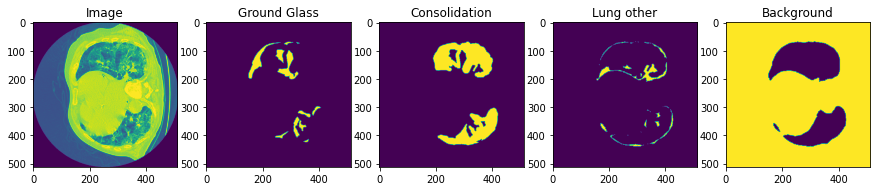

In [7]:
image = 0
fig, ax = plt.subplots(1,5,figsize=(15,15))
plt.grid = False
ax[0].imshow(images_medseg[image,:,:,0])
ax[0].set_title('Image')
ax[1].imshow(masks_medseg[image,:,:,0])
ax[1].set_title('Ground Glass')
ax[2].imshow(masks_medseg[image,:,:,1])
ax[2].set_title('Consolidation')
ax[3].imshow(masks_medseg[image,:,:,2])
ax[3].set_title('Lung other')
ax[4].imshow(masks_medseg[image,:,:,3])
ax[4].set_title('Background')

### Display a Radiopedia image with masks

Text(0.5, 1.0, 'Background')

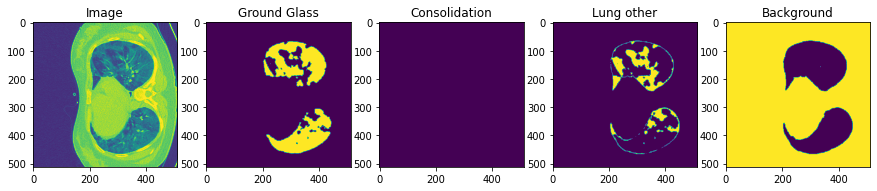

In [8]:
image = 100
fig, ax = plt.subplots(1,5,figsize=(15,15))
plt.grid = False
ax[0].imshow(images_radiopedia[image,:,:,0])
ax[0].set_title('Image')
ax[1].imshow(masks_radiopedia[image,:,:,0])
ax[1].set_title('Ground Glass')
ax[2].imshow(masks_radiopedia[image,:,:,1])
ax[2].set_title('Consolidation')
ax[3].imshow(masks_radiopedia[image,:,:,2])
ax[3].set_title('Lung other')
ax[4].imshow(masks_radiopedia[image,:,:,3])
ax[4].set_title('Background')

In [9]:
# Merge the images/masks
merged_images = np.append(images_medseg, images_radiopedia, axis=0)
merged_masks = np.append(masks_medseg, masks_radiopedia, axis=0)

In [10]:
# Stack image for 3 channels to mimic RGB
output_channels = 3
stacked_images = np.ndarray(shape=(merged_images.shape[0], 512, 512, output_channels), dtype='float32')
for i in trange(merged_images.shape[0]):
    for channel in range(output_channels):
        stacked_images[i,:,:,channel] = merged_images[i,:,:,0]

merged_images = stacked_images

In [11]:
print(f'Merged images: {merged_images.shape}')
print(f'Merged masks: {merged_masks.shape}')

Merged images: (929, 512, 512, 3)
Merged masks: (929, 512, 512, 4)


### Create training/testing sets

In [12]:
# Split into training/testing sets
print('Splitting image sets into train/test...')
x_train, x_test, y_train, y_test = train_test_split(merged_images, merged_masks, test_size=0.33, random_state=42)
print('Done')

Splitting image sets into train/test...
Done


# Define model
Here we use the [segmentation-models](https://github.com/qubvel/segmentation_models) package. There are four models available: **UNet**, **LinkNet**, **PSPNet**, and **FPN**. The encoder section for each model can be swapped with 24 different architectures included with Keras, such as VGG and ResNet variations, each with pretrained weights from the ImageNet dataset. For more information, see the [documentation](https://segmentation-models.readthedocs.io/en/latest/).

### Create a Mirrored Strategy
Running a model with a Tensorflow MirroredStrategy allows the model to be trained across multiple GPUs. It is still compatible with single GPU or CPU training, so this code can be run on any cluster. The amount of memory (RAM or GPU) available will affect the available batch size.   

In [13]:
# How much GPU memory is available
# If model is already instantiated, this will be very low
gpu_memory = get_gpu_memory()
print(f'Available GPU memory: {gpu_memory/1000} GB')

Available GPU memory: 10.567 GB


In [14]:
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


### Build or load model
This is set up to use the classic UNet model if `use_imagenet = False` or to use the segmentation-models package  with a ResNet-34 encoder structure and ImageNet weights. **Note:** ImageNet images are RGB and therefore three channels, so if you have greyscale images (like CT images), they must be converted to three channels by stacking the image.

In [15]:
######## Path to the model = None, otherwise path to your model file
model_path = None
use_imagenet = True

# Open a strategy scope.
with strategy.scope():
    if model_path:
        print('Loading model...')
        model = tf.keras.models.load_model(model_path)
        print('Done')
    
    else:
        print('Building model...')
        # Instantiate model
        metrics=['categorical_accuracy']
        optimizer = SGD(lr=0.01, momentum=0.99)
        loss = 'binary_crossentropy'
        # This uses the segmentation models package
        model = sm.FPN(backbone_name='resnet34', encoder_weights='imagenet', input_shape=(512,512,3), classes=4)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
        print('Done')


Building model...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
IN

In [16]:
# Adjust batch size here for available GPU memory
batch_size = 7 # This will depend on how much GPU memory
model_size = get_model_memory_usage(batch_size, model)
print(f'Model size: {model_size} GB')

Model size: 9.073 GB


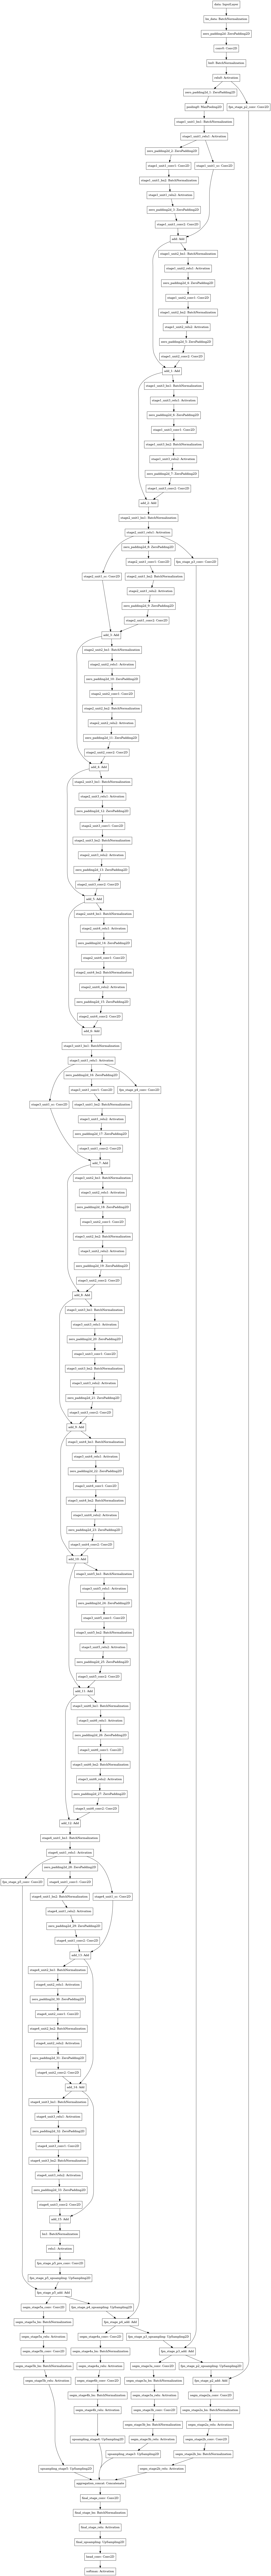

In [17]:
plot_model(model)

### Create data generators
One of the pitfalls of a small dataset is training a model to predict those few images very well, but losing accuracy when applying the model to a broader range of images. Fortunately, we can artifically increase the size and variability of our dataset by using rotation, zoom, and panning. Keras has the built-in class `ImageDataGenerator` for this purpose.

**Note:** it is imperative that the images and masks are provided with the same seed to both the image and mask data generators. This keeps the images and masks in the same order with the same augmentation applied to both.

In [18]:
print('Creating data generators...')
# Define some parameters for data augmentation
data_gen_args = dict(#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)

# Instantiate data generators
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
# for data and masks so they stay paired
seed = 1
image_datagen.fit(x_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(x_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)
train_generator = zip(image_generator, mask_generator)
print('Done')


Creating data generators...
Done


### Train model

In [19]:
# This is set up for a 
model_path = 'covid_fpn.h5'
epoch_steps = 100
epochs = 25

if model_path is None:
    model_path = 'unet.h5'

# Train the model
print('Training model')
model_checkpoint = ModelCheckpoint(model_path, monitor='categorical_accuracy', verbose=1, save_best_only=True)
H = model.fit(train_generator, steps_per_epoch=epoch_steps, epochs=epochs, callbacks=model_checkpoint)

# Save loss history
loss_history = np.array(H.history['loss'])
np.savetxt("loss_history.csv", loss_history, delimiter=",")


Training model
Epoch 1/25
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
100/100 [==============================] - ETA: 0s - loss: 0.1029 - categorical_accuracy: 0.9261
Epoch 00001: categorical_accuracy improved from -inf to 0.92610, saving model to covid_fpn.h5
100/100 [==============================] - 49s 488ms/step - loss: 0.1029 - categorical_accuracy: 0.9261
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.0349 - categorical_accuracy: 0.9732
Epoch 00002: categorical_accuracy improved from 0.92610 to 0.97322, saving model to covid_fpn.h5
100/100 [==============================] - 48s 485ms/step - loss: 0.0349 - categorical_accuracy: 0.9732
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.0291 - categorical_accuracy: 0.9778
Epoch 00003: categorical_accuracy improved from 0.97322 to 0.97777, saving model to covid_fpn.h5
100/100 [==============================] - 49s 494ms/step - loss: 0.0291 - categori

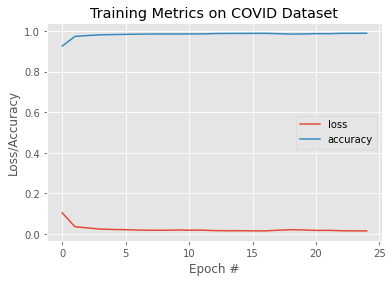

In [20]:
# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="loss")
plt.plot(np.arange(0, N), H.history["categorical_accuracy"], label="accuracy")
plt.title("Training Metrics on COVID Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")

### Test model

In [21]:
#model = load_model('fpn.h5')
# Test the model
test_datagen = ImageDataGenerator()
test_datagen.fit(x_test)
test_generator = test_datagen.flow(x_test, y_test, batch_size=4)

test_results = model.evaluate(test_generator)


77/77 [==============================] - 7s 85ms/step - loss: 0.0142 - categorical_accuracy: 0.9892


## Predict and display results

In [22]:
#model = load_model('semantic_unet.h5')
# Evaluate the model
# TODO: replace x_test (Covid images) with COPDGene images, move to separate script
predict_results = model.predict(x_test, batch_size=10, verbose=1)

31/31 [==============================] - 6s 190ms/step


In [23]:
# These functions are for overlaying the masks and predictions on the original image
def mask_to_rgba(mask, color='red'):
    h = mask.shape[0]
    w = mask.shape[1]
    zeros = np.zeros((h, w))
    ones = np.ones((h, w))
    if color == "red":
        return np.stack((mask, zeros, zeros, mask), axis=-1)
    elif color == "green":
        return np.stack((zeros, mask, zeros, mask), axis=-1)
    elif color == "blue":
        return np.stack((zeros, zeros, mask, mask), axis=-1)
    elif color == "yellow":
        return np.stack((mask, mask, zeros, mask), axis=-1)
    elif color == "magenta":
        return np.stack((mask, zeros, mask, mask), axis=-1)
    elif color == "cyan":
        return np.stack((zeros, mask, mask, mask), axis=-1)
    elif color == 'col1':
        r,g,b = 160, 196, 255
        return np.stack((mask*(r/255),mask*(g/255),mask*(b/255),mask), axis=-1)
    elif color == 'col2':
        r,g,b = 255, 173, 173
        return np.stack((mask*(r/255),mask*(g/255),mask*(b/255),mask), axis=-1)
    elif color == 'col3':
        r,g,b = 253, 255, 182
        return np.stack((mask*(r/255),mask*(g/255),mask*(b/255),mask), axis=-1)
    
def mask_zero_values(image, threshold=0.01):
    masked_image = np.ma.masked_where(image<threshold, image)
    return masked_image

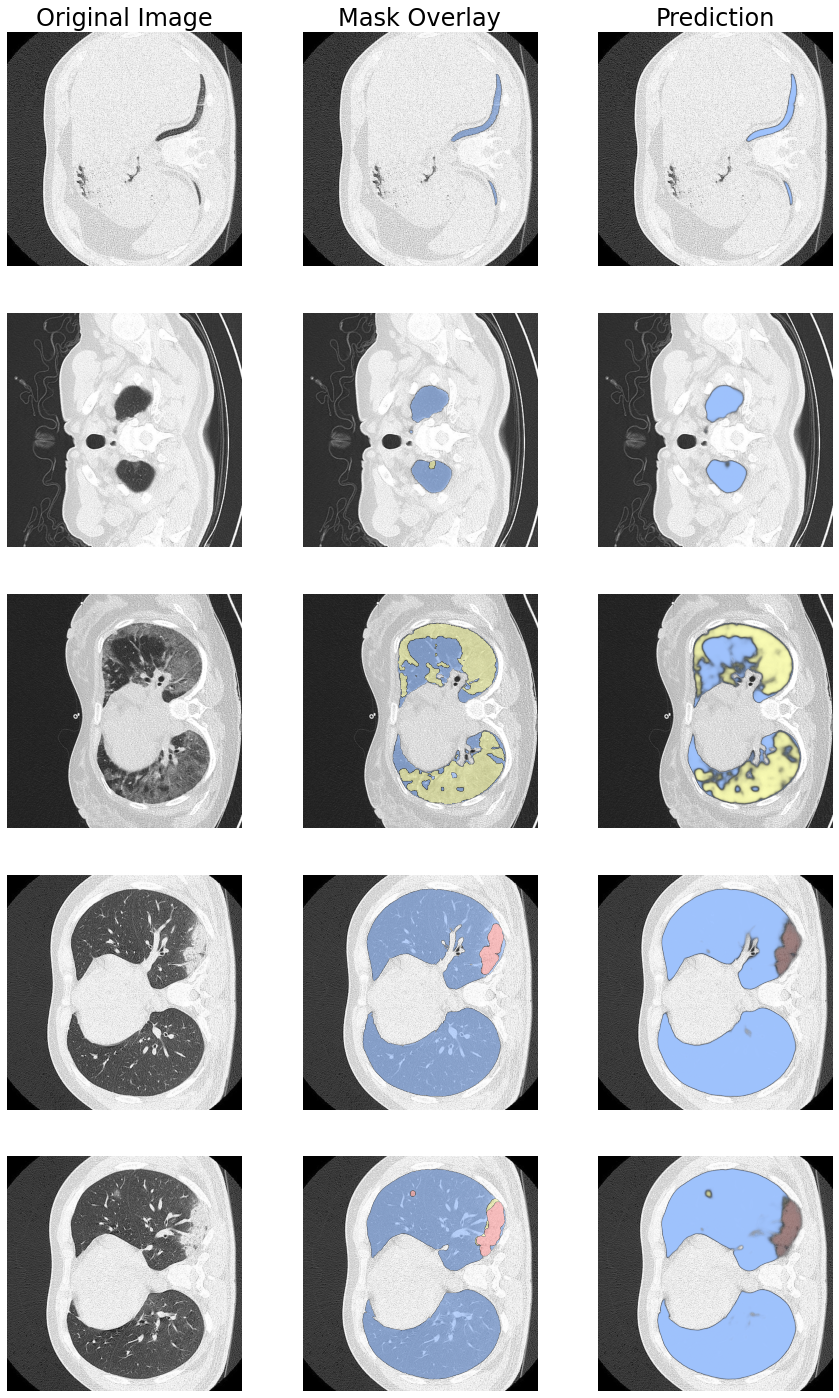

In [24]:
# Display a few images with masks and predictions
num_imgs = 5
image_index = [*range(y_test.shape[0])]
image = random.sample(image_index, k=num_imgs)
figsize = 5
fig, ax = plt.subplots(num_imgs, 3, figsize=(3 * figsize, num_imgs * figsize), squeeze=False)
ax[0, 0].set_title("Original Image", fontsize=24)
ax[0, 1].set_title("Mask Overlay", fontsize=24)
ax[0, 2].set_title("Prediction", fontsize=24)
for m in range(0, num_imgs):
    ax[m,0].imshow(x_test[image[m],:,:,0], cmap=plt.cm.gray)
    ax[m,0].axis('off')
    ax[m,1].imshow(x_test[image[m],:,:,0], cmap=plt.cm.gray)
    ax[m,1].imshow(mask_to_rgba(mask_zero_values(y_test[image[m],:,:,0]), color='col3'), alpha=0.7)
    ax[m,1].imshow(mask_to_rgba(mask_zero_values(y_test[image[m],:,:,1]), color='col2'), alpha=0.7)
    ax[m,1].imshow(mask_to_rgba(mask_zero_values(y_test[image[m],:,:,2]), color='col1'), alpha=0.7)
    ax[m,1].axis('off')
    ax[m,2].imshow(x_test[image[m],:,:,0], cmap=plt.cm.gray)
    ax[m,2].imshow(mask_to_rgba(mask_zero_values(predict_results[image[m],:,:,0]), color='col3'))
    ax[m,2].imshow(mask_to_rgba(mask_zero_values(predict_results[image[m],:,:,1]), color='col2'))
    ax[m,2].imshow(mask_to_rgba(mask_zero_values(predict_results[image[m],:,:,2]), color='col1'))
    ax[m,2].axis('off')
    

## Calculate the accuracy of our model
The model is very good at figuring out where the background and normal lungs are, but because those classes make up a vast majority of the pixels in the whole dataset, they artificially inflate the pixelwise categorical accuracy. Thus our accuracy approaches 99% while training. A more appropriate measure is an [F-score](https://en.wikipedia.org/wiki/F-score), which is basically the fraction of true postives.

To calculate the F-score, we will first need to establish to which class each pixel is predicted to belong, then compare to the original mask values.

In [25]:
# Identify most probable class for each pixel
# and create a one-hot predicted mask
# predict: direct output from model.predict()
def best_cat(predict):
    positives = np.ndarray((predict.shape[0],512,512,predict.shape[3]))
    for i in trange(predict.shape[0]):
        for y in range(512):
            for x in range(512):
                pixel_values = predict[i,y,x,:]
                max_ind = np.argmax(pixel_values)
                positives[i,y,x,:] = 0
                positives[i,y,x,max_ind] = 1
    return positives

# Calculate an F1-score for each class for each image
# test: original masks, as int
# predict: one-hot masks of predicted best category
def calc_f1(test, predict):
    f1_scores = np.zeros((test.shape[0],test.shape[3]))
    for i in trange(test.shape[0]):
        for z in range(test.shape[3]):
            test_total = np.sum(test[i,:,:,z])
            predict_total = np.sum(predict[i,:,:,z])
            fp_fn = np.sum(np.abs(test[i,:,:,z]-predict[i,:,:,z]))
            combined = test[i,:,:,z] + predict[i,:,:,z]
            union_count = np.where(combined == 2)
            tp = union_count[0].size
            f1_scores[i,z] = tp/(tp + (0.5 * fp_fn))
    return f1_scores


In [26]:
positives = best_cat(predict_results)

In [27]:
y_int = y_test.astype(int)

# Get an array F1 scores for each class in each image
f1_scores = calc_f1(y_int, positives)

/home/moopers/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


In [28]:
# In case any images have no mask values,
# find and replace them with NaN
for i in range(y_test.shape[0]):
    for z in range(y_test.shape[3]):
        if np.amax(y_test[i,:,:,z]) == 0:
            f1_scores[i,z] = np.nan

In [29]:
# Calculate mean f1 scores excluding NaNs for each class
background_f1 = np.nanmean(f1_scores[:,3])
lung_f1 = np.nanmean(f1_scores[:,2])
ground_glass_f1 = np.nanmean(f1_scores[:,0])
consolidation_f1 = np.nanmean(f1_scores[:,1])
print('F1 scores: 0-1')
print(f'bg {background_f1}, lung {lung_f1}, ground glass {ground_glass_f1}, consolidation {consolidation_f1}')

F1 scores: 0-1
bg 0.9969755040542475, lung 0.9299325492035195, ground glass 0.5935139004931741, consolidation 0.566899899916608


### Conclusions
The F1 scores confirm that the model can accurately differentiate between the areas inside and outside of the lungs. It is also highly accurate when identifying "lung other," likely a result of numerous healthy lung images. The limitation comes from differentiating the pathology from healthy lung.<br />
<br />
Increasing the size of the dataset is a priority for increasing the accuracy of the model. Additionally, we can convert the F1 evaluation into a custom metric in place of categorical accuracy, giving us an additional monitor for learning while we train.

In [30]:
# This will clear your GPU memory, and also probably kill the kernel
from numba import cuda
cuda.select_device(0)
cuda.close()